In [1]:
import joblib, matplotlib.pyplot as plt, os, glob, pandas as pd, numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import adjusted_rand_score

In [2]:
DEFAULT_COLS = [
    'age','sex','cp','trestbps','chol','fbs','restecg',
    'thalach','exang','oldpeak','slope','ca','thal','num'
]

In [3]:
def _try_read_csv(path):
    for sep in [',', r'\s+', ';', '\t']:
        try:
            df = pd.read_csv(path, header=None, sep=sep, engine='python', na_values=['?',''])
            df = df.dropna(how='all')
            if df.shape[1] >= 5:
                return df
        except Exception:
            continue
    with open(path, 'r', errors='ignore') as f:
        lines = [l.strip() for l in f if l.strip()]
    rows = [l.split() for l in lines]
    maxcols = max(len(r) for r in rows)
    rows = [r + [np.nan]*(maxcols-len(r)) for r in rows]
    return pd.DataFrame(rows)

In [4]:
def find_data_files(data_dir='data'):
    patterns = [os.path.join(data_dir, 'processed.*.data'),
                os.path.join(data_dir, '*.data'),
                os.path.join(data_dir, '*.csv')]
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return sorted(list(dict.fromkeys(files)))

In [5]:
def load_and_combine_data(data_dir='data'):
    if not os.path.exists(data_dir):
        alt_path = os.path.join("..", data_dir)
        if os.path.exists(alt_path):
            data_dir = alt_path

    files = find_data_files(data_dir)
    if not files:
        raise FileNotFoundError(f"No data files found in {data_dir}")

    parts = [_try_read_csv(f) for f in files]
    df = pd.concat(parts, ignore_index=True, sort=False)

    if df.shape[1] == len(DEFAULT_COLS):
        df.columns = DEFAULT_COLS
    else:
        n = min(len(DEFAULT_COLS), df.shape[1])
        df.columns = DEFAULT_COLS[:n] + [f'col_{i}' for i in range(n, df.shape[1])]

    df.replace(['?', '\x00', '\x00\x00', 'NA', 'na', 'null'], np.nan, inplace=True)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    if 'target' not in df.columns:
        if 'num' in df.columns:
            df['target'] = df['num'].apply(lambda x: 1 if (pd.notna(x) and x > 0) else 0)
        else:
            raise ValueError("No 'num' or 'target' column found.")

    id_cols = [c for c in df.columns if 'id' in c.lower()]
    feature_cols = [c for c in df.columns if c not in (id_cols + ['target','num'])]

    return {
        'original': df.copy(),
        'features': df[feature_cols].copy(),
        'targets': df[['target']].copy(),
        'ids': df[id_cols].copy() if id_cols else pd.DataFrame(index=df.index),
        'headers': list(df.columns)
    }

In [6]:
dataset = load_and_combine_data("data")
X = dataset["features"]
y = dataset["targets"]["target"]

In [7]:
preproc = joblib.load("models/preprocessor.pkl")
X_proc = preproc.fit_transform(X)

In [8]:
distortions = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_proc)
    distortions.append(km.inertia_)

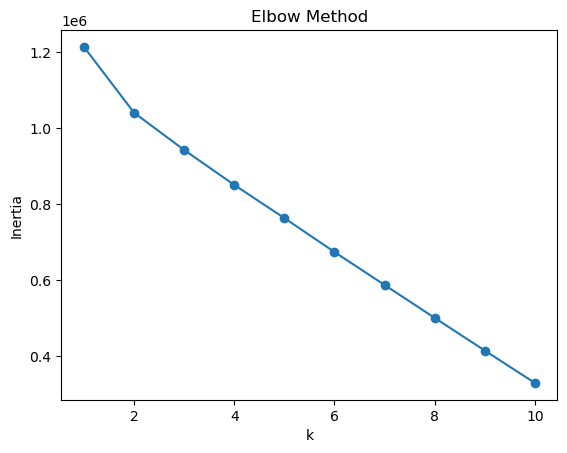

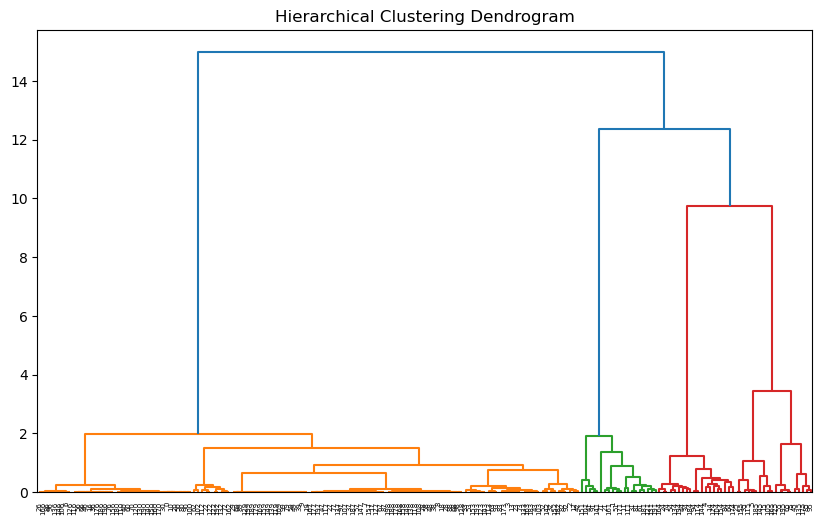

In [9]:
plt.plot(range(1,11), distortions, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram")
shc.dendrogram(shc.linkage(X_proc[:200], method='ward'))
plt.show()

In [34]:
kmeans = KMeans(n_clusters=6, random_state=40, n_init=100).fit(X_proc)

In [35]:
print("ARI (KMeans vs true):", adjusted_rand_score(y, kmeans.labels_))

ARI (KMeans vs true): -0.025746739743138687


In [38]:
sample_size = min(20000, X_proc.shape[0])
X_sample = X_proc[:sample_size]
y_sample = y.iloc[:sample_size] 

In [ ]:
agg = AgglomerativeClustering(n_clusters=2).fit(X_sample)

In [ ]:

print("ARI (Agglomerative vs true):", adjusted_rand_score(y_sample, agg.labels_))


ARI (Agglomerative vs true): 0.004495980269410233
